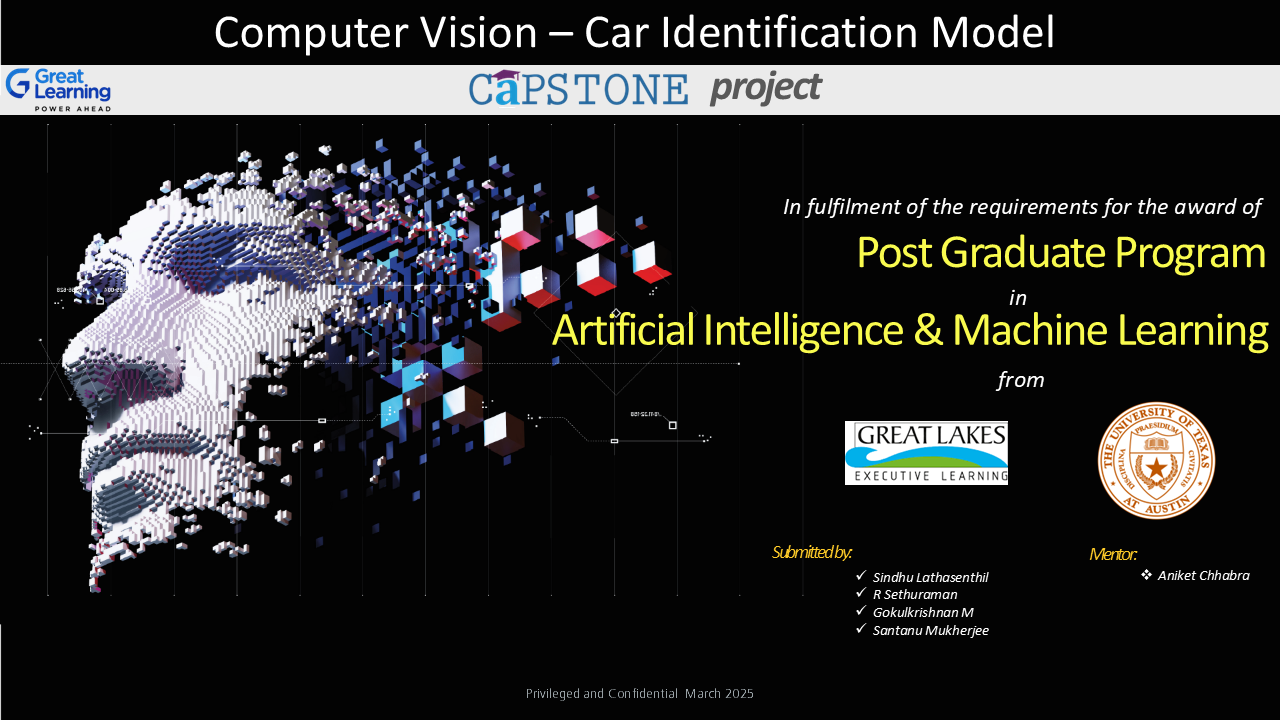

# **COMPUTER VISION CAPSTONE PROJECT AIML OBJECT DETECTION - CAR**

In [1]:
from prettytable import PrettyTable

# Create a PrettyTable object
table = PrettyTable()

# Define the columns
table.field_names = ["S.NO", "Contents", "Cell Number"]

# Add rows
table.add_row([1, "Problem Statement", 4 ])
table.add_row([2, "Introduction", 6])
table.add_row([3, "Libraries Used", 7])
table.add_row([4, "Data Handling", 8 ])
table.add_row(["4A", "Data Handling - Import Data", 8 ])
table.add_row(["4B", "Data Handling - Map Images w.r.t Classes", 15 ])
table.add_row(["4C", "Data Handling - Map Images w.r.t Annotations", 18 ])
table.add_row([5, "Display Result - bounding box", 22 ])
table.add_row([6, "Design Basic CNN Models", 25 ])
table.add_row(["6A", "MobileNetV2 CNN Model", 34 ])
table.add_row(["6B", "Google CNN Model", 44 ])
table.add_row(["6C", "AlexNet CNN Model", 49 ])
table.add_row(["6D", "U-Net CNN Model", 57 ])
table.add_row(["7", "Summary", 64 ])
# Print the table
print(table)

+------+----------------------------------------------+-------------+
| S.NO |                   Contents                   | Cell Number |
+------+----------------------------------------------+-------------+
|  1   |              Problem Statement               |      4      |
|  2   |                 Introduction                 |      6      |
|  3   |                Libraries Used                |      7      |
|  4   |                Data Handling                 |      8      |
|  4A  |         Data Handling - Import Data          |      8      |
|  4B  |   Data Handling - Map Images w.r.t Classes   |      15     |
|  4C  | Data Handling - Map Images w.r.t Annotations |      18     |
|  5   |        Display Result - bounding box         |      22     |
|  6   |           Design Basic CNN Models            |      25     |
|  6A  |            MobileNetV2 CNN Model             |      34     |
|  6B  |               Google CNN Model               |      44     |
|  6C  |            

1. Problem Statement



Computer vision can be used to automate supervision and generate action appropriate action trigger if the event is
predicted from the image of interest. For example a car moving on the road can be easily identified by a camera as make of
the car, type, colour, number plates etc.

Design a DL based car identification model.

2. Introduction

The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing
images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g.
2012 Tesla Model S or 2012 BMW M3 coupe.

Data description:

‣ Train Images: Consists of real images of cars as per the make and year of the car.

‣ Test Images: Consists of real images of cars as per the make and year of the car.

‣ Train Annotation: Consists of bounding box region for training images.

‣ Test Annotation: Consists of bounding box region for testing images.


3. Libraries Used

In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #for visualization
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image # For image loading and manipulation
from pathlib import Path

import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import ResNet50

4. Data Handling



4A. Data Handling - Import Data

In [3]:
# Define file paths
car_names_file = 'Car names and make.csv'
annotations_zip_file = 'Annotations.zip'
images_zip_file = 'Car Images.zip'

# Step 1: Load the car names and make data
car_names_df = pd.read_csv(car_names_file)

# Display the first few rows of the DataFrame
print("Car Names and Makes:")
print(car_names_df.head())

# Step 2: Extract Annotations.zip
with zipfile.ZipFile(annotations_zip_file, 'r') as zip_ref:
    zip_ref.extractall('Annotations')

# List the extracted files
print("\nExtracted Annotations:")
print(os.listdir('Annotations'))

# Step 3: Extract Car Images.zip
with zipfile.ZipFile(images_zip_file, 'r') as zip_ref:
    zip_ref.extractall('Car_Images')

# List the extracted files
print("\nExtracted Car Images:")
print(os.listdir('Car_Images'))

Car Names and Makes:
  AM General Hummer SUV 2000
0        Acura RL Sedan 2012
1        Acura TL Sedan 2012
2       Acura TL Type-S 2008
3       Acura TSX Sedan 2012
4  Acura Integra Type R 2001

Extracted Annotations:
['Annotations', 'Test Annotation.csv', 'Train Annotations.csv']

Extracted Car Images:
['Car Images', 'Generated_Masks']


In [4]:
# Load the training annotations
train_annotations_path = r'Train Annotations.csv'  # Adjust the path as necessary
train_annotations_df = pd.read_csv(train_annotations_path)
print("Training Annotations Columns:")
print(train_annotations_df.columns)
train_annotations_df.head(5)

Training Annotations Columns:
Index(['Image Name', 'Bounding Box coordinates', 'Unnamed: 2', 'Unnamed: 3',
       'Unnamed: 4', 'Image class'],
      dtype='object')


Image Name  Bounding Box coordinates  Unnamed: 2  Unnamed: 3  Unnamed: 4  \
0  00001.jpg                        39         116         569         375   
1  00002.jpg                        36         116         868         587   
2  00003.jpg                        85         109         601         381   
3  00004.jpg                       621         393        1484        1096   
4  00005.jpg                        14          36         133          99   

   Image class  
0           14  
1            3  
2           91  
3          134  
4          106

In [5]:
# Load the Test annotations
test_annotations_path = r'Test Annotation.csv'  # Adjust the path as necessary
test_annotations_df = pd.read_csv(test_annotations_path)
print("Test Annotations Columns:")
print(test_annotations_df.columns)
test_annotations_df.head(5)

Test Annotations Columns:
Index(['Image Name', 'Bounding Box coordinates', 'Unnamed: 2', 'Unnamed: 3',
       'Unnamed: 4', 'Image class'],
      dtype='object')


Image Name  Bounding Box coordinates  Unnamed: 2  Unnamed: 3  Unnamed: 4  \
0  00001.jpg                        30          52         246         147   
1  00002.jpg                       100          19         576         203   
2  00003.jpg                        51         105         968         659   
3  00004.jpg                        67          84         581         407   
4  00005.jpg                       140         151         593         339   

   Image class  
0          181  
1          103  
2          145  
3          187  
4          185

In [6]:
# Renaming column names
train_annotations_df = train_annotations_df.rename(columns={'Bounding Box coordinates':'Bounding Box coordinates_xmin','Unnamed: 2':'Bounding Box coordinates_ymin','Unnamed: 3':'Bounding Box coordinates_xmax','Unnamed: 4':'Bounding Box coordinates_ymax'})
train_annotations_df.head(5)

Image Name  Bounding Box coordinates_xmin  Bounding Box coordinates_ymin  \
0  00001.jpg                             39                            116   
1  00002.jpg                             36                            116   
2  00003.jpg                             85                            109   
3  00004.jpg                            621                            393   
4  00005.jpg                             14                             36   

   Bounding Box coordinates_xmax  Bounding Box coordinates_ymax  Image class  
0                            569                            375           14  
1                            868                            587            3  
2                            601                            381           91  
3                           1484                           1096          134  
4                            133                             99          106

In [7]:
# Renaming column names
test_annotations_df = test_annotations_df.rename(columns={'Bounding Box coordinates':'Bounding Box coordinates_xmin','Unnamed: 2':'Bounding Box coordinates_ymin','Unnamed: 3':'Bounding Box coordinates_xmax','Unnamed: 4':'Bounding Box coordinates_ymax'})
test_annotations_df.head(5)

Image Name  Bounding Box coordinates_xmin  Bounding Box coordinates_ymin  \
0  00001.jpg                             30                             52   
1  00002.jpg                            100                             19   
2  00003.jpg                             51                            105   
3  00004.jpg                             67                             84   
4  00005.jpg                            140                            151   

   Bounding Box coordinates_xmax  Bounding Box coordinates_ymax  Image class  
0                            246                            147          181  
1                            576                            203          103  
2                            968                            659          145  
3                            581                            407          187  
4                            593                            339          185

In [ ]:
# for images
base_dir = Path(r"D:\PGDIMPLOMA\Classes\CAPSTONEPROJECT\INTEGRATED_FILE\Car_Images") #replace the directory accordingly
train_images_path = base_dir / "Car Images" / "Train Images"
test_images_path  = base_dir / "Car Images" / "Test Images"
train_images_path = Path(train_images_path).resolve()
test_images_path = Path(test_images_path).resolve()


4B. Data Handling - Map Images w.r.t Classes

In [ ]:
#Train Images class mapping
#Folder where multiple train images are stored
train_class_folders = [f.path for f in os.scandir(train_images_path) if f.is_dir()]
train_image_classes = {} # Dictionary to store training image: class mapping
train_images_path = list(train_images_path.rglob("*.jpg")) 

# Create a dictionary mapping image filenames to class names (parent folder)
train_image_classes = {img_path.name: img_path.parent.name for img_path in train_images_path}

# Define columns for the Training DataFrame
columns_training = ['Image_Path', 'labels']

# Create an empty DataFrame
df_training = pd.DataFrame(columns=columns_training)
df_training = pd.DataFrame(train_images_path, columns=["Image_Path"])
df_training["labels"] = df_training["Image_Path"].apply(lambda x: Path(x).parent.name) 
df_training["Image_Path"] = df_training["Image_Path"].apply(lambda x: str(Path(x).resolve()))
df_training["Image_Path"] = df_training["Image_Path"].astype(str)
print(df_training.head(10))

# --- Print a few mappings to verify ---
print("Sample Training Image to Class Mappings:")
count = 0
for img_name, class_label in list(train_image_classes.items())[:5]:
    print(f"{img_name}: {class_label}")




                                          Image_Path  \
0  D:\PGDIMPLOMA\Classes\CAPSTONEPROJECT\INTEGRAT...   
1  D:\PGDIMPLOMA\Classes\CAPSTONEPROJECT\INTEGRAT...   
2  D:\PGDIMPLOMA\Classes\CAPSTONEPROJECT\INTEGRAT...   
3  D:\PGDIMPLOMA\Classes\CAPSTONEPROJECT\INTEGRAT...   
4  D:\PGDIMPLOMA\Classes\CAPSTONEPROJECT\INTEGRAT...   
5  D:\PGDIMPLOMA\Classes\CAPSTONEPROJECT\INTEGRAT...   
6  D:\PGDIMPLOMA\Classes\CAPSTONEPROJECT\INTEGRAT...   
7  D:\PGDIMPLOMA\Classes\CAPSTONEPROJECT\INTEGRAT...   
8  D:\PGDIMPLOMA\Classes\CAPSTONEPROJECT\INTEGRAT...   
9  D:\PGDIMPLOMA\Classes\CAPSTONEPROJECT\INTEGRAT...   

                      labels  
0  Acura Integra Type R 2001  
1  Acura Integra Type R 2001  
2  Acura Integra Type R 2001  
3  Acura Integra Type R 2001  
4  Acura Integra Type R 2001  
5  Acura Integra Type R 2001  
6  Acura Integra Type R 2001  
7  Acura Integra Type R 2001  
8  Acura Integra Type R 2001  
9  Acura Integra Type R 2001  
Sample Training Image to Class Mappings:
0

In [ ]:
#Test Images class mapping
#Folder where multiple test images are stored
test_class_folders = [f.path for f in os.scandir(test_images_path) if f.is_dir()]
test_image_classes = {}  # Dictionary to store testing image: class mapping
test_images_path = list(test_images_path.rglob("*.jpg"))

# Create a dictionary mapping image filenames to class names (parent folder)
test_image_classes = {img_path.name: img_path.parent.name for img_path in test_images_path}

# Define columns for the Testing DataFrame
columns_testing = ['Image_Path', 'labels']

# Create an empty DataFrame
df_testing = pd.DataFrame(columns=columns_testing)      
df_testing = pd.DataFrame(test_images_path, columns=["Image_Path"])
df_testing["labels"] = df_testing["Image_Path"].apply(lambda x: Path(x).parent.name)
df_testing["Image_Path"] = df_testing["Image_Path"].apply(lambda x: str(Path(x).resolve()))
df_testing["Image_Path"] = df_testing["Image_Path"].astype(str)

print(df_testing.head(10))

print("Sample Testing Image to Class Mappings:")
count = 0
for img_name, class_label in list(test_image_classes.items())[:5]:
    print(f"{img_name}: {class_label}")




                                          Image_Path  \
0  D:\PGDIMPLOMA\Classes\CAPSTONEPROJECT\INTEGRAT...   
1  D:\PGDIMPLOMA\Classes\CAPSTONEPROJECT\INTEGRAT...   
2  D:\PGDIMPLOMA\Classes\CAPSTONEPROJECT\INTEGRAT...   
3  D:\PGDIMPLOMA\Classes\CAPSTONEPROJECT\INTEGRAT...   
4  D:\PGDIMPLOMA\Classes\CAPSTONEPROJECT\INTEGRAT...   
5  D:\PGDIMPLOMA\Classes\CAPSTONEPROJECT\INTEGRAT...   
6  D:\PGDIMPLOMA\Classes\CAPSTONEPROJECT\INTEGRAT...   
7  D:\PGDIMPLOMA\Classes\CAPSTONEPROJECT\INTEGRAT...   
8  D:\PGDIMPLOMA\Classes\CAPSTONEPROJECT\INTEGRAT...   
9  D:\PGDIMPLOMA\Classes\CAPSTONEPROJECT\INTEGRAT...   

                      labels  
0  Acura Integra Type R 2001  
1  Acura Integra Type R 2001  
2  Acura Integra Type R 2001  
3  Acura Integra Type R 2001  
4  Acura Integra Type R 2001  
5  Acura Integra Type R 2001  
6  Acura Integra Type R 2001  
7  Acura Integra Type R 2001  
8  Acura Integra Type R 2001  
9  Acura Integra Type R 2001  
Sample Testing Image to Class Mappings:
00

4C. Data Handling - Map Images w.r.t Annotations

In [11]:
# ********Definition of the method ********************************
def map_images_to_bboxes(annotations_file):
    image_bboxes = {}
    try:
        for index, row in annotations_file.iterrows():
                image_name = row['Image Name']
                x_min = row['Bounding Box coordinates_xmin']
                y_min = row['Bounding Box coordinates_ymin']
                x_max = row['Bounding Box coordinates_xmax']
                y_max = row['Bounding Box coordinates_ymax']
                image_class = row['Image class']

                image_bboxes[image_name] = (x_min, y_min, x_max, y_max) # Store bbox as tuple

    except FileNotFoundError:
        print(f"Error: Annotation file not found: {annotations_file}")
    except KeyError as e:
        print(f"Error: Column '{e}' not found in CSV file. Check your CSV column names.")
        print("Expected columns (example): filename, xmin, ymin, xmax, ymax") # Example expected columns

    return image_bboxes



In [ ]:
#Train images boundry box mapping
train_image_bboxes = map_images_to_bboxes(train_annotations_df)
# --- Print a few mappings to verify for Training images ---
print("\nSample Training Image to Bounding Box Mappings (DF):")
count = 0
for img_name, bbox in train_image_bboxes.items():
    print(f"{img_name}: {bbox}")
    count += 1
    if count > 5: break




Sample Training Image to Bounding Box Mappings (DF):
00001.jpg: (39, 116, 569, 375)
00002.jpg: (36, 116, 868, 587)
00003.jpg: (85, 109, 601, 381)
00004.jpg: (621, 393, 1484, 1096)
00005.jpg: (14, 36, 133, 99)
00006.jpg: (259, 289, 515, 416)


In [ ]:
#Test images boundry box mapping
test_image_bboxes = map_images_to_bboxes(test_annotations_df)
# --- Print a few mappings to verify  testing images---
print("\nSample Testing Image to Bounding Box Mappings (DF):")
count = 0
for img_name, bbox in test_image_bboxes.items():
    print(f"{img_name}: {bbox}")
    count += 1
    if count > 5: break


Sample Testing Image to Bounding Box Mappings (DF):
00001.jpg: (30, 52, 246, 147)
00002.jpg: (100, 19, 576, 203)
00003.jpg: (51, 105, 968, 659)
00004.jpg: (67, 84, 581, 407)
00005.jpg: (140, 151, 593, 339)
00006.jpg: (20, 77, 420, 301)


5. Display Result - bounding box

In [14]:
# Display images with bounding boxes
def display_image_with_bbox(image_path, annotation):
    # Load image
    img = Image.open(image_path)

    # Create plot
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Draw bounding box
    x_min = row['Bounding Box coordinates_xmin']
    y_min = row['Bounding Box coordinates_ymin']
    x_max = row['Bounding Box coordinates_xmax']
    y_max = row['Bounding Box coordinates_ymax']
    image_class = row['Image class']
    bbox = annotation['bbox']
    rect = patches.Rectangle(
        (x_min, y_min),  # (x_min, y_min) -  (bbox[0], bbox[1])
        (x_max - x_min),   # width (x_max - x_min)  - bbox[2] - bbox[0]
        (y_max - y_min),   # height (y_max - y_min) -- bbox[3] - bbox[1]
        linewidth=2,
        edgecolor='r',
        facecolor='none'
    )
    ax.add_patch(rect)

    # Add class label
    plt.text(
        bbox[0], bbox[1] - 10,  # Position of the label
        annotation['image_class'],
        color='red',
        fontsize=12,
        backgroundcolor='white'
    )

    plt.axis('off')
    plt.show()

For Training Images


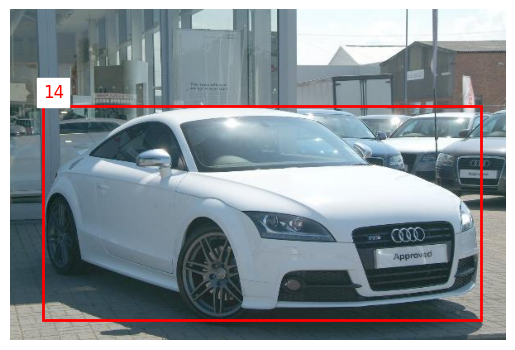

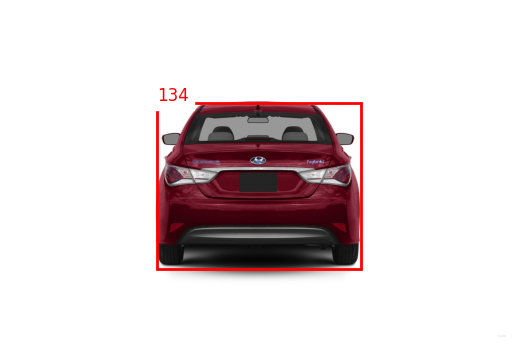

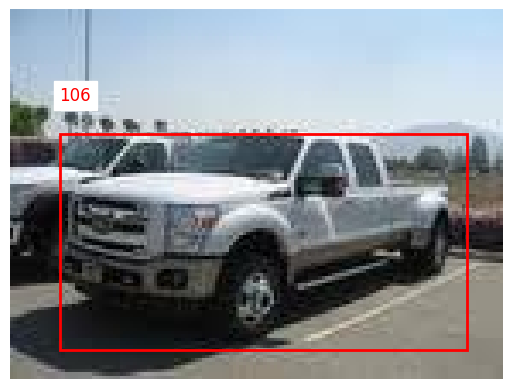

Displayed 5 training images with bounding boxes.


In [ ]:
# Display bounding box for train images
print("For Training Images") 
displayed_image_count = 0  # Initialize a counter to track displayed images

image_paths_details_training=[]
images_paths_details_testing=[]

for index, row in train_annotations_df.iterrows():
    if displayed_image_count >= 5: # Check if we've already displayed two images
        break  # If yes, exit the loop

    image_name = str(row['Image Name']).strip()
    image_path = None # Initialize image_path to None

    for class_folder in train_class_folders:
        potential_image_path = os.path.join(class_folder, image_name)
        if os.path.exists(potential_image_path):
            image_path = potential_image_path
            image_paths_details_training.append(potential_image_path)
            break # Image found, no need to check other class folders

    if image_path: # If image_path is found (not None)
        annotation = {
            'bbox': [row['Bounding Box coordinates_xmin'], row['Bounding Box coordinates_ymin'], row['Bounding Box coordinates_xmax'], row['Bounding Box coordinates_ymax']],
            'image_class' : row['Image class']
        }
        display_image_with_bbox(image_path, annotation)
        displayed_image_count += 1 # Increment the counter

print(f"Displayed {displayed_image_count} training images with bounding boxes.")

For Testing Images


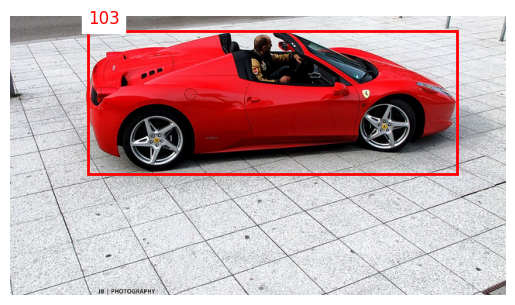

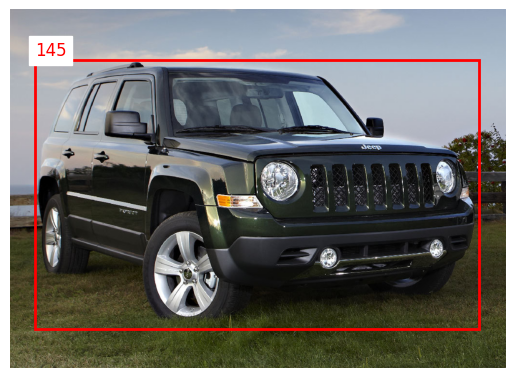

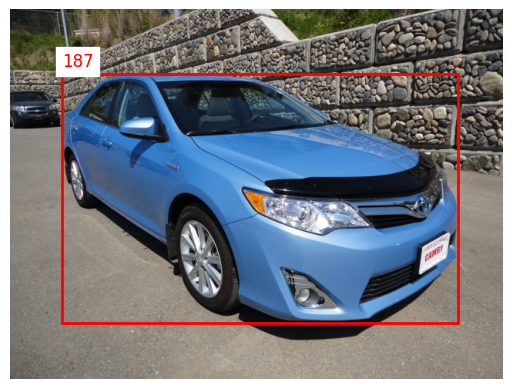

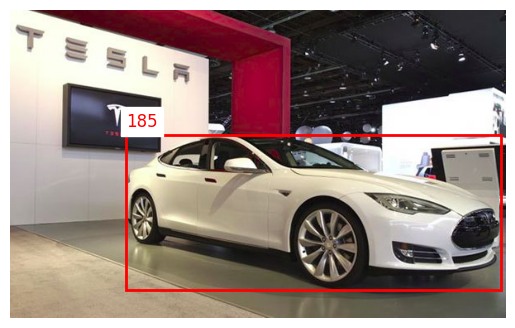

Displayed 5 test images with bounding boxes.


In [ ]:
# Display bounding box for test images
print("For Testing Images") 
displayed_image_count_test = 0  # Initialize a counter to track displayed images

for index, row in test_annotations_df.iterrows():  # Use test_annotations_df DataFrame
    if displayed_image_count_test >= 5: # Check if we've already displayed two images (adjust number here if you want 5 or more)
        break  # If yes, exit the loop

    image_name_test = str(row['Image Name']).strip()
    image_path_test = None # Initialize image_path_test to None

    for class_folder in test_class_folders: # Use test_class_folders
        potential_image_path_test = os.path.join(class_folder, image_name_test)
        if os.path.exists(potential_image_path_test):
            image_path_test = potential_image_path_test # Assigned to image_path_test
            images_paths_details_testing.append(potential_image_path)
            break # Image found, no need to check other class folders

    if image_path_test: # If image_path_test is found (not None)
        annotation_test = {
            'bbox': [row['Bounding Box coordinates_xmin'], row['Bounding Box coordinates_ymin'], row['Bounding Box coordinates_xmax'], row['Bounding Box coordinates_ymax']],
            'image_class' : row['Image class'] # Assuming 'Image class' column also exists in test_annotations_df (verify!)
        }
        display_image_with_bbox(image_path_test, annotation_test)  # Changed here
        displayed_image_count_test += 1 # Increment the counter

print(f"Displayed {displayed_image_count_test} test images with bounding boxes.") 




6. Design Basic CNN Models


The Models designed are:

1. MobileNetV2
2. GoogleNet
3. AlexNet
4. ResNet

In [ ]:
def preprocess_image(image_path, target_size=(224, 224)):
    """
    Load and preprocess an image for CNN input.
    """
    # Check if the image file exists
    if not os.path.exists(image_path):
        print(f"Warning: Image file not found: {image_path}")
        return None  # Or handle the missing image in a way that makes sense for your application

    image = cv2.imread(image_path)  # Load image

    # Check if image loading was successful
    if image is None:
        print(f"Warning: Failed to load image: {image_path}")
        return None  # Or handle the loading error as needed

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = cv2.resize(image, target_size)  # Resize to target size
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image

In [18]:
def custom_generator(df, batch_size, target_size):
    """
    Custom generator for images and labels.
    """
    num_samples = len(df)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_samples = df.iloc[offset:offset + batch_size]
            images = []
            labels = []
            for _, row in batch_samples.iterrows():
                image = preprocess_image(row['Image_Path'], target_size)
                label = row['label_categorical']
                images.append(image)
                labels.append(label)
            X = np.array(images)
            y = np.array(labels)
            yield X, y

In [19]:
# Apply preprocessing to all images
df_testing['image'] = df_testing['Image_Path'].apply(preprocess_image)
df_training['image'] = df_training['Image_Path'].apply(preprocess_image)

# Check for and handle None values in the 'image' column
df_testing = df_testing.dropna(subset=['image'])  # Remove rows with None in 'image'
df_training = df_training.dropna(subset=['image'])  # Remove rows with None in 'image'

In [20]:
# Encode labels
label_encoder = LabelEncoder()
df_testing['labels_encoded'] = label_encoder.fit_transform(df_testing['labels'])
df_training['labels_encoded'] = label_encoder.fit_transform(df_training['labels'])

# Convert labels to categorical (one-hot encoding)
df_testing['label_categorical'] = df_testing['labels_encoded'].apply(lambda x: to_categorical(x, num_classes=len(test_class_folders)))
df_training['label_categorical'] = df_training['labels_encoded'].apply(lambda x: to_categorical(x, num_classes=len(test_class_folders)))

In [21]:
# Split df_training into training and validation sets
df_train, df_val = train_test_split(df_training, test_size=0.2, random_state=42)

In [ ]:
# Create generators
batch_size = 32
train_generator = custom_generator(df_train, batch_size, target_size=(224, 224))
val_generator = custom_generator(df_val, batch_size, target_size=(224, 224))  # Use df_val for validation
# Test generator remains the same
test_generator = custom_generator(df_testing, batch_size, target_size=(224, 224))

In [23]:
# Check training generator
X_batch, y_batch = next(train_generator)
print("Training batch shape:", X_batch.shape, y_batch.shape)

# Check validation generator
X_batch, y_batch = next(val_generator)
print("Validation batch shape:", X_batch.shape, y_batch.shape)

Training batch shape: (32, 224, 224, 3) (32, 196)
Validation batch shape: (32, 224, 224, 3) (32, 196)


In [24]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.show()

6A. MobileNetV2

In [25]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))  # Use 128x128 for speed

In [26]:
# Freeze all but last 4 layers for efficient training
for layer in base_model.layers[:-4]:  
    layer.trainable = False  

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduces parameters
x = BatchNormalization()(x)  # Stabilizes training
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)  # Dropout for regularization
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)  # Output layer

In [ ]:
#Split 80-20 of train images
df_train_mobilenet, df_val_mobilenet = train_test_split(df_training, test_size=0.2, random_state=42)

In [ ]:
mobilenet_batch_size=16
df_train_mobilenet_gen = custom_generator(df_train_mobilenet,mobilenet_batch_size,target_size=(128,128))
df_val_mobilenet_gen = custom_generator(df_val_mobilenet,mobilenet_batch_size,target_size=(128,128))

In [29]:
# Create the model
mobilenet_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
mobilenet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
mobilenet_model.summary()

# Define steps per epoch
steps_per_epoch = np.ceil(len(df_train_mobilenet) / mobilenet_batch_size).astype(int)
validation_steps = np.ceil(len(df_val_mobilenet) / mobilenet_batch_size).astype(int)

y_true = np.array(df_train_mobilenet['labels_encoded'].tolist())

# Compute class weights based on actual class distribution
class_weights = compute_class_weight('balanced', classes=np.unique(y_true), y=y_true)
class_weight_dict = dict(enumerate(class_weights))

#predicting
history_mobilenet = mobilenet_model.fit(
     df_train_mobilenet_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=df_val_mobilenet_gen,
    validation_steps=validation_steps,
    epochs=10  # Reduce epochs to speed up training
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 64, 64, 32)        │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 64, 64, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 64, 64, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 64, 64, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 64, 64, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 64, 64, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 64, 64, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 64, 64, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 64, 64, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 64, 64, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 64, 64, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 65, 65, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 32, 32, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,452,356 (9.35 MB)

 Trainable params: 604,612 (2.31 MB)

 Non-trainable params: 1,847,744 (7.05 MB)

Epoch 1/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 127s 285ms/step - accuracy: 0.0076 - loss: 5.6136 - val_accuracy: 0.0325 - val_loss: 5.0620
Epoch 2/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 103s 254ms/step - accuracy: 0.0868 - loss: 4.5848 - val_accuracy: 0.0731 - val_loss: 4.6919
Epoch 3/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 109s 266ms/step - accuracy: 0.1732 - loss: 3.9772 - val_accuracy: 0.0988 - val_loss: 4.4104
Epoch 4/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 114s 280ms/step - accuracy: 0.2814 - loss: 3.4665 - val_accuracy: 0.1283 - val_loss: 4.1942
Epoch 5/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 122s 299ms/step - accuracy: 0.3732 - loss: 2.9963 - val_accuracy: 0.1461 - val_loss: 4.0151
Epoch 6/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 109s 268ms/step - accuracy: 0.4678 - loss: 2.6040 - val_accuracy: 0.1614 - val_loss: 3.8753
Epoch 7/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 114s 281ms/step - accuracy: 0.5545 - loss: 2.2405 - val_accuracy: 0.1731 - val_loss: 3.7598
Epoch 8/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 112s 275ms/step - accuracy: 0.6195 -

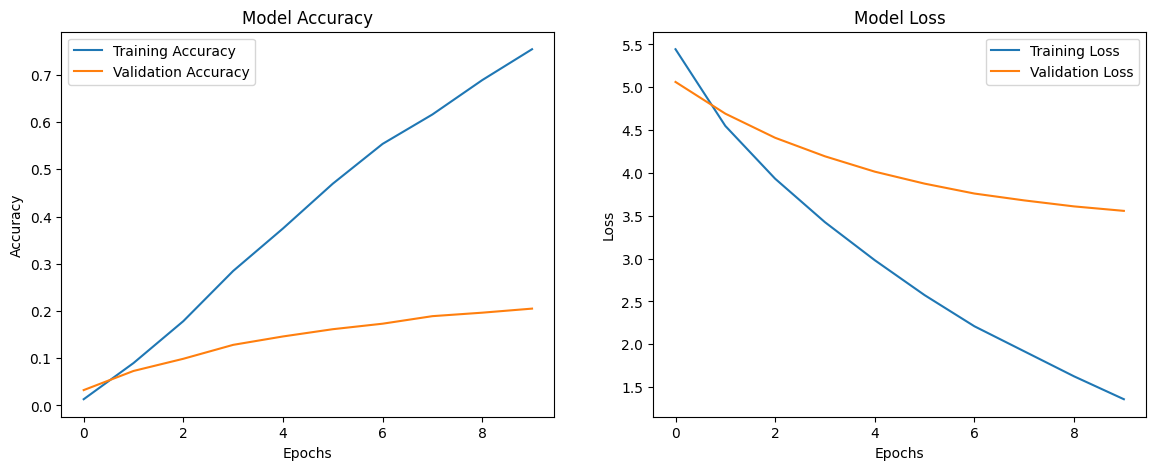

In [ ]:
#display model accurance and loss
plot_training_history(history_mobilenet)

In [35]:
# Initialize lists for true and predicted labels
y_true = []
y_pred = []

# Generate predictions batch-wise
for i in range(validation_steps):
    X_batch, y_batch = next(df_val_mobilenet_gen)  # Fetch batch
    
    # Predict on batch
    y_pred_batch = np.argmax(mobilenet_model.predict(X_batch), axis=1)
    y_true_batch = np.argmax(y_batch, axis=1)

    # Store results
    y_pred.extend(y_pred_batch)
    y_true.extend(y_true_batch)

# Generate and print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, zero_division=1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 378s 378s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

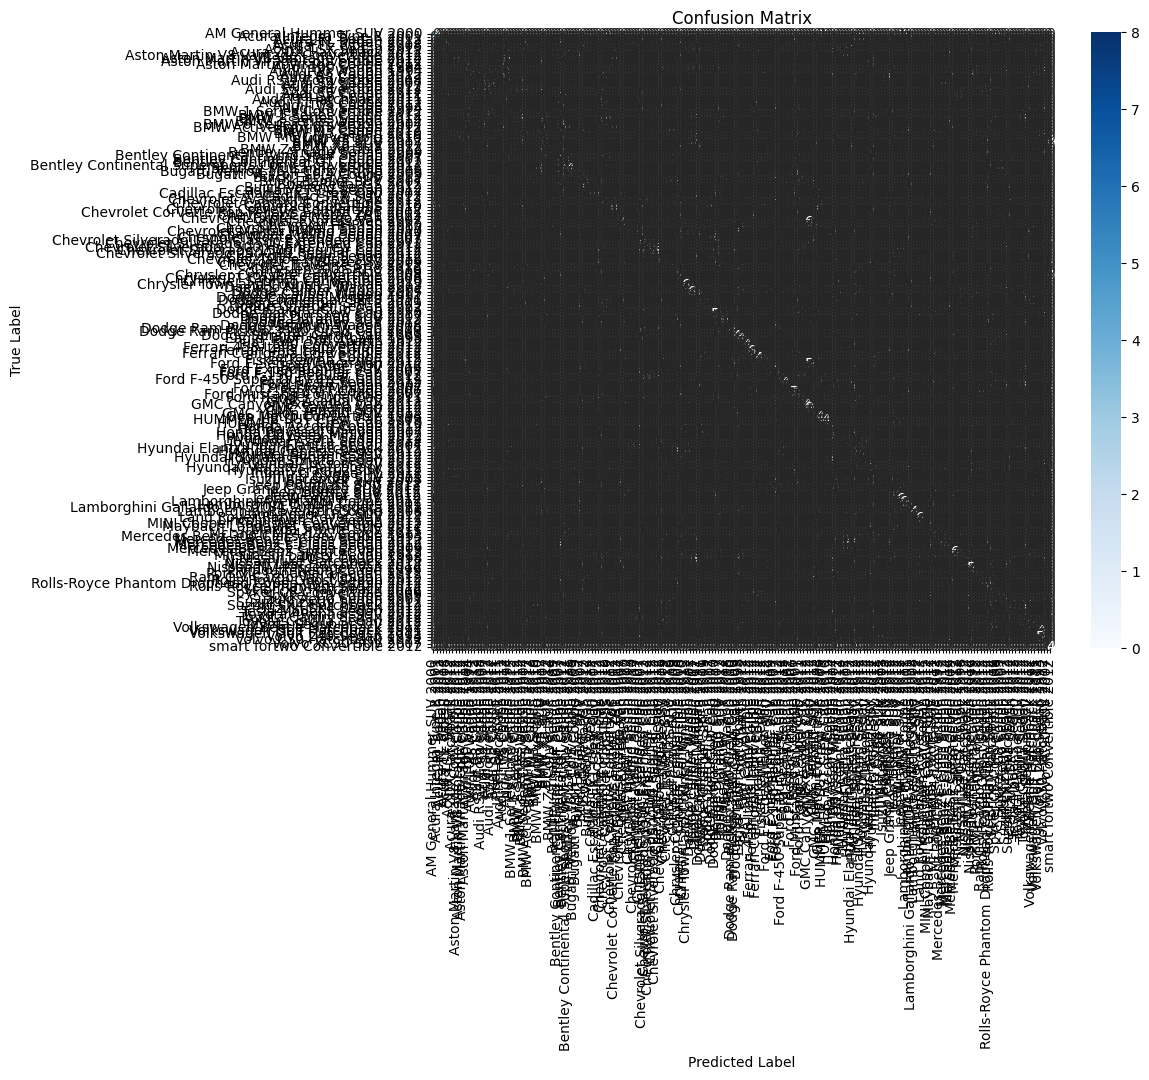

In [ ]:
# plot heatmap predicated vs true label
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


##### **MobileNet Model Summary**
- Poor Generalization of The Model
- Based on the Classification report most cases are not predicted correctly.
- Indications of Database Imbalance is present
-  lightweight model for real-time applications on mobile devices but here car classification and labeling needed
**Next Steps**
  
- handle data imbalance
- parameter tuning for to enhance performance


6B. GoogleNet

In [37]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(196, activation='softmax')(x)

# Define the complete model
googlenet_model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
googlenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Convert to numpy arrays
# Ensure all images have the same shape before stacking
# Ensure the model summary is called after defining the model
googlenet_model.summary()

history_googlenet= googlenet_model.fit(
    train_generator,  # Uses batches from the generator
    steps_per_epoch=len(df_train) // batch_size,  # Number of batches per epoch
    epochs=10,
    validation_data=val_generator,  # Uses batches from the validation generator
    validation_steps=len(df_val) // batch_size,  # Number of validation batches per epoch
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 111, 111, 32)      │             864 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 111, 111, 32)      │              96 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 111, 111, 32)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 109, 109, 32)      │           9,216 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 109, 109, 32)      │              96 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 109, 109, 32)      │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 109, 109, 64)      │          18,432 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 109, 109, 64)      │             192 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 109, 109, 64)      │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 54, 54, 64)        │               0 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 54, 54, 80)        │           5,120 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_4         │ (None, 54, 54, 80)        │             240 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 54, 54, 80)        │               0 │ batch_normalization_4[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 52, 52, 192)       │         138,240 │ activation_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 24,101,860 (91.94 MB)

 Trainable params: 2,299,076 (8.77 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 558s 3s/step - accuracy: 0.0502 - loss: 4.9661 - val_accuracy: 0.1008 - val_loss: 3.9183
Epoch 2/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 522s 3s/step - accuracy: 0.1570 - loss: 3.5118 - val_accuracy: 0.1522 - val_loss: 3.6039
Epoch 3/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 487s 2s/step - accuracy: 0.2437 - loss: 2.9909 - val_accuracy: 0.1737 - val_loss: 3.3955
Epoch 4/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 504s 2s/step - accuracy: 0.3354 - loss: 2.5922 - val_accuracy: 0.1935 - val_loss: 3.3317
Epoch 5/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.4203 - loss: 2.2169 - val_accuracy: 0.2135 - val_loss: 3.2759
Epoch 6/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - accuracy: 0.4997 - loss: 1.9239 - val_accuracy: 0.2379 - val_loss: 3.2412
Epoch 7/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.5711 - loss: 1.6550 - val_accuracy: 0.2379 - val_loss: 3.3062
Epoch 8/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/step - accuracy: 0.6282 - loss: 1.4253 - val_accu

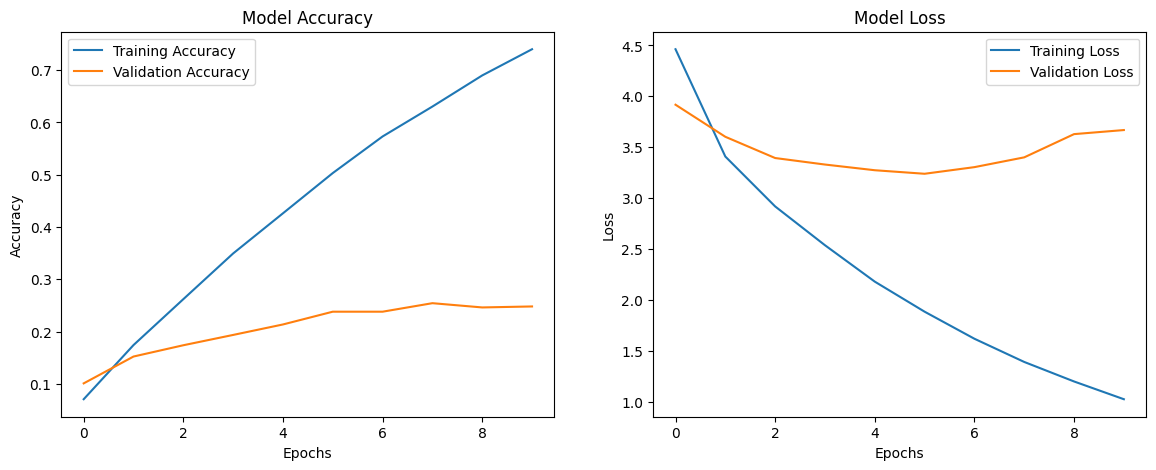

In [ ]:
#display model accuracy vs model loss
plot_training_history(history_googlenet)

In [ ]:
# Convert validation generator data into NumPy arrays
X_val = np.array([img for img in df_val['image']])  # Extract images
y_val_true = np.array([np.argmax(label) for label in df_val['label_categorical']])  # Extract true labels

# Predict on entire validation set at once
y_val_pred = np.argmax(googlenet_model.predict(X_val), axis=1)

# Generate and print classification report
print(classification_report(y_val_true, y_val_pred, target_names=label_encoder.classes_, zero_division=1))



51/51 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step
                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000       0.50      0.57      0.53         7
                             Acura Integra Type R 2001       0.38      0.38      0.38         8
                                   Acura RL Sedan 2012       1.00      0.00      0.00         9
                                   Acura TL Sedan 2012       0.09      0.15      0.11        13
                                  Acura TL Type-S 2008       0.00      0.00      0.00         5
                                  Acura TSX Sedan 2012       0.14      0.09      0.11        11
                              Acura ZDX Hatchback 2012       0.33      0.14      0.20         7
              Aston Martin V8 Vantage Convertible 2012       0.40      0.20      0.27        10
                    Aston Martin V8 Vantage Coupe 2012       0.50      0.12      0.20         8


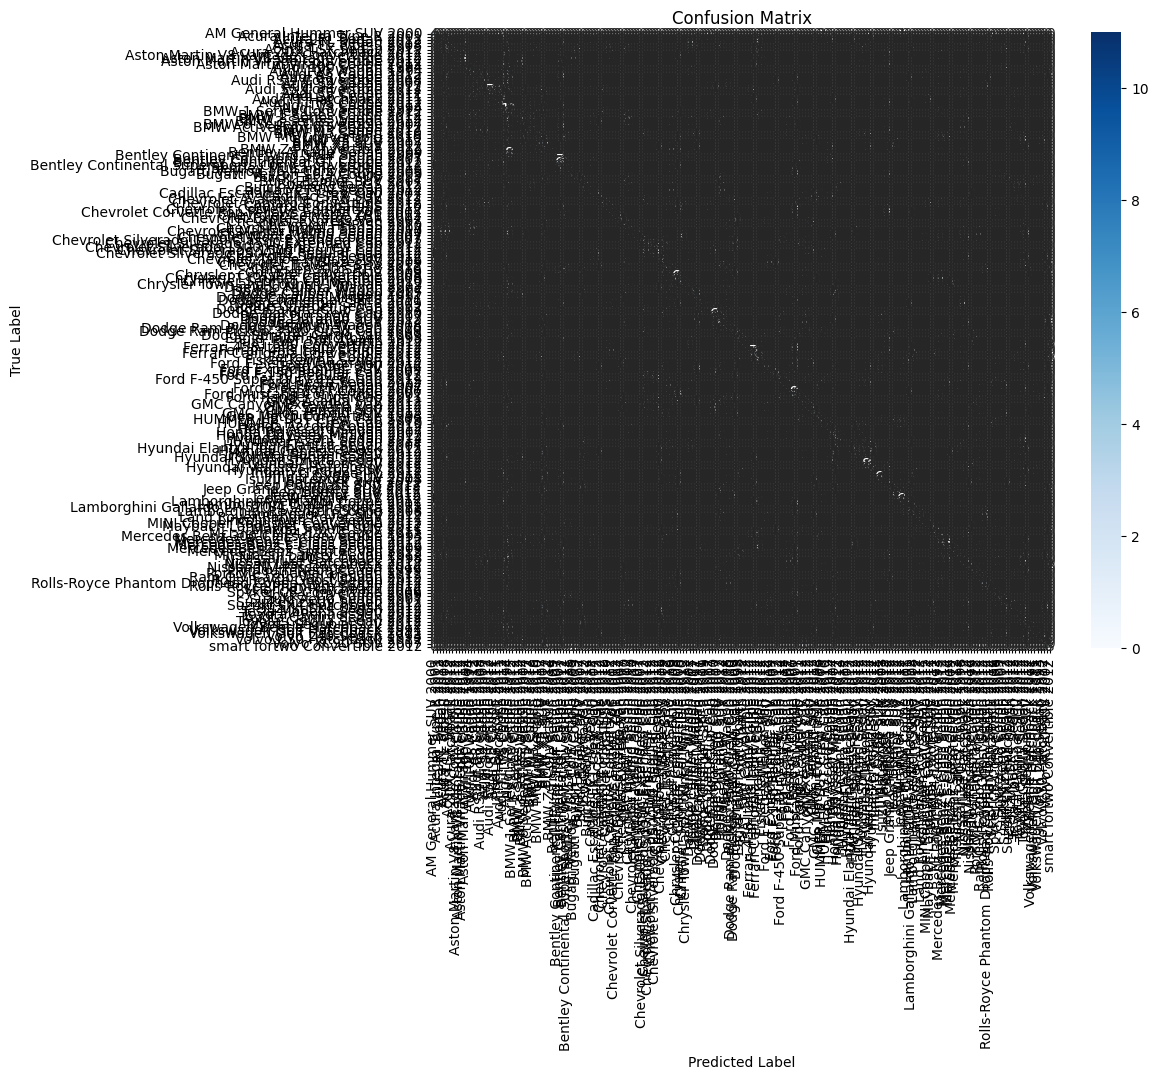

In [ ]:
#display heatmap of predicted label vs true label
cm = confusion_matrix(y_val_true, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

##### **Googlenet Summary**

 The inception modules allow the model to learn features at different scales, which can be beneficial for detecting cars of various sizes and orientations.
 
Training Accuracy: Steadily increases, reaching ~75%. 
Validation Accuracy: Stagnates around 20-25%, indicating poor generalization.
Training Loss: Decreases smoothly, showing effective learning on training data.

Validation Loss: Plateaus and increases after a few epochs, a sign of overfitting.
    
Classification Report Analysis:
Overall Accuracy: 25%, indicating poor performance on validation data.
Precision: ~41%
Recall: ~26% (Very Low)
F1-Score: ~24%

Key Issues Identified:
Indicates skewed performance, likely due to class imbalance.
Overfitting.
High Bias (Poor Performance on Validation Data)
Potential Class Imbalance

6C. AlexNet

In [ ]:
# Define paths
image_dir = 'Car_Images/Car Images/Test Images'  # Adjust based on your directory structure

# Prepare data
images = []
labels = []

for index, row in test_annotations_df.iterrows():
    image_name = row['Image Name']
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (227, 227))  # Resize to 227x227 pixels (AlexNet input size)
    images.append(image)

    # Assuming 'Image class' contains the class label
    labels.append(row['Image class'])

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Encode labels
unique_classes = np.unique(labels)


In [ ]:
def create_alexnet_model(input_shape, num_classes):
    model = Sequential()

    # First Convolutional Layer
    model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())

    # Second Convolutional Layer
    model.add(Conv2D(256, (5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())

    # Third Convolutional Layer
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Fourth Convolutional Layer
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Fifth Convolutional Layer
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())

    # Flatten the output
    model.add(Flatten())

    # Fully Connected Layers
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))

    return model

# Create the model
input_shape = (224, 224, 3)  # Image dimensions for AlexNet

#num_classes = len(unique_classes)

num_classes = len(df_training['labels'].unique())

model = create_alexnet_model(input_shape, num_classes)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2,
                             height_shift_range=0.2, shear_range=0.2,
                             zoom_range=0.2, horizontal_flip=True,
                             fill_mode='nearest')

epochs=10
batch_size=32

train_steps = len(df_train) // batch_size
val_steps = len(df_val) // batch_size
model.summary()

alexnet_history = model.fit(
    train_generator,  
    steps_per_epoch = train_steps,
    epochs=epochs,
    batch_size=32,    
    validation_data=val_generator,
    validation_steps=val_steps
)

D:\Program Files\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_94 (Conv2D)                   │ (None, 54, 54, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 26, 26, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_95               │ (None, 26, 26, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_95 (Conv2D)                   │ (None, 26, 26, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_96               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_96 (Conv2D)                   │ (None, 12, 12, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_97 (Conv2D)                   │ (None, 12, 12, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_98 (Conv2D)                   │ (None, 12, 12, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_97               │ (None, 5, 5, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4096)                │      26,218,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 196)                 │         803,012 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,552,452 (181.40 MB)

 Trainable params: 47,551,236 (181.39 MB)

 Non-trainable params: 1,216 (4.75 KB)

Epoch 1/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - accuracy: 0.0056 - loss: 6.1040 - val_accuracy: 0.0044 - val_loss: 5.3195
Epoch 2/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 291s 1s/step - accuracy: 0.0050 - loss: 5.2955 - val_accuracy: 0.0075 - val_loss: 5.2820
Epoch 3/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - accuracy: 0.0083 - loss: 5.2799 - val_accuracy: 0.0075 - val_loss: 5.2859
Epoch 4/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 284s 1s/step - accuracy: 0.0082 - loss: 5.2784 - val_accuracy: 0.0075 - val_loss: 5.2896
Epoch 5/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - accuracy: 0.0080 - loss: 5.2761 - val_accuracy: 0.0075 - val_loss: 5.2927
Epoch 6/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - accuracy: 0.0088 - loss: 5.2738 - val_accuracy: 0.0075 - val_loss: 5.2955
Epoch 7/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 286s 1s/step - accuracy: 0.0085 - loss: 5.2729 - val_accuracy: 0.0075 - val_loss: 5.2963
Epoch 8/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - accuracy: 0.0092 - loss: 5.2720 - val_accu

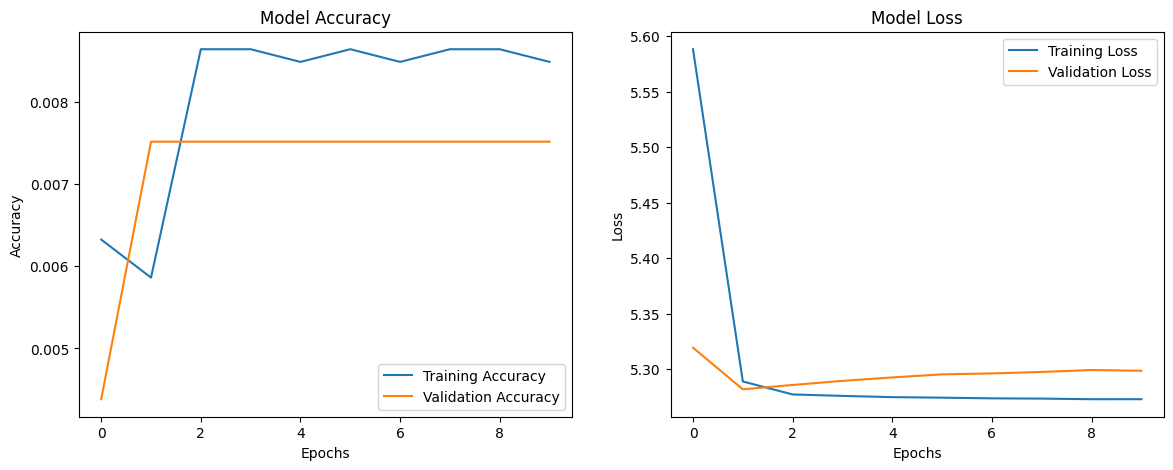

In [ ]:
#display model accuracy vs loss
plot_training_history(alexnet_history)

In [47]:
X_val = np.array([img for img in df_val['image']])
y_val_true = np.array([np.argmax(label) for label in df_val['label_categorical']])

# Predict in one go
y_val_pred = np.argmax(model.predict(X_val), axis=1)

# Compute and display confusion matrix
conf_matrix = confusion_matrix(y_val_true, y_val_pred)

51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 357ms/step


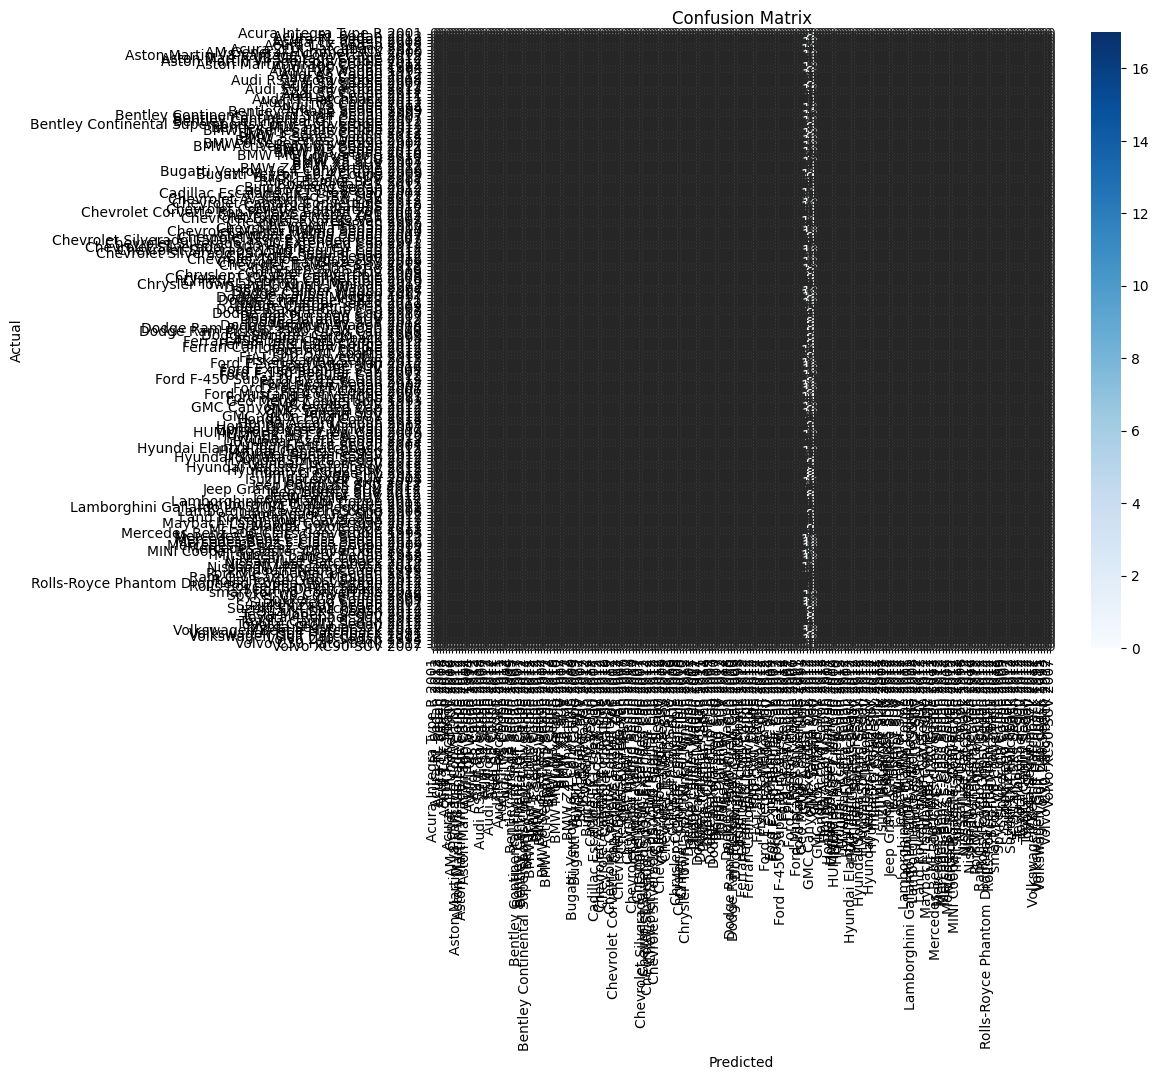

In [48]:
# Display confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df_training['labels'].unique(), yticklabels=df_training['labels'].unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [49]:
# Print Classification Report
print("Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=df_training['labels'].unique(), zero_division=0))

Classification Report:
                                                        precision    recall  f1-score   support

                             Acura Integra Type R 2001       0.00      0.00      0.00         7
                                   Acura RL Sedan 2012       0.00      0.00      0.00         8
                                   Acura TL Sedan 2012       0.00      0.00      0.00         9
                                  Acura TL Type-S 2008       0.00      0.00      0.00        13
                                  Acura TSX Sedan 2012       0.00      0.00      0.00         5
                              Acura ZDX Hatchback 2012       0.00      0.00      0.00        11
                            AM General Hummer SUV 2000       0.00      0.00      0.00         7
              Aston Martin V8 Vantage Convertible 2012       0.00      0.00      0.00        10
                    Aston Martin V8 Vantage Coupe 2012       0.00      0.00      0.00         8
                

#### **Observation For Alexnet Model**
- The Model is not learning appropriately since the Training Accuracy and Validation accuracy are pretty low
- There is huge value loss in both training as well as validation datasets which indicates that the model is not performing well
- We have the accuracy reported as none in the classification report. which inidicates that the model is not performing well
  
**Further Actions that can be taken are** 

- Increaase Data Augmentation for the model to perform well, in the training data set.
- Possible class imbalance
- Parameter tuning

6D. ResNet

In [50]:
# Load ResNet50 base model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(df_training['labels_encoded'].unique()), activation='softmax')(x)  # Output layer

# Define model
resnet_model = Model(inputs=base_model.input, outputs=x)

# Compile model
resnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
resnet_model.summary()


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 24,737,348 (94.37 MB)

 Trainable params: 1,149,636 (4.39 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [51]:
epochs = 10
steps_per_epoch = len(df_train) // batch_size
validation_steps = len(df_val) // batch_size

resnet_history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=epochs
)

Epoch 1/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - accuracy: 0.0087 - loss: 5.2714 - val_accuracy: 0.0075 - val_loss: 5.2994
Epoch 2/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.0094 - loss: 5.2716 - val_accuracy: 0.0075 - val_loss: 5.2983
Epoch 3/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.0090 - loss: 5.2708 - val_accuracy: 0.0075 - val_loss: 5.2979
Epoch 4/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.0088 - loss: 5.2707 - val_accuracy: 0.0069 - val_loss: 5.2986
Epoch 5/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - accuracy: 0.0095 - loss: 5.2698 - val_accuracy: 0.0069 - val_loss: 5.3003
Epoch 6/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.0091 - loss: 5.2706 - val_accuracy: 0.0069 - val_loss: 5.3011
Epoch 7/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 347s 2s/step - accuracy: 0.0089 - loss: 5.2701 - val_accuracy: 0.0075 - val_loss: 5.3015
Epoch 8/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.0087 - loss: 5.2710 - val_accu

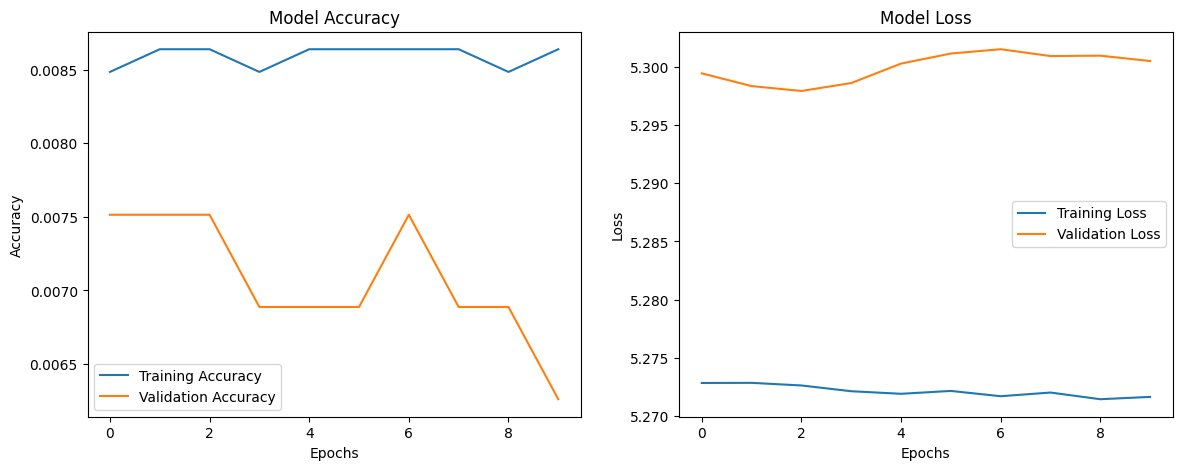

In [53]:
#accuracy loss graph
plot_training_history(resnet_history)



In [54]:
X_val = np.array([img for img in df_val['image']])  # Extract images
y_val_true = np.array([np.argmax(label) for label in df_val['label_categorical']])  # Extract true labels

# Predict on entire validation set at once
y_val_pred = np.argmax(resnet_model.predict(X_val), axis=1)

# Generate and print classification report
print("Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=label_encoder.classes_, zero_division=1))


51/51 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step
Classification Report:
                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000       1.00      0.00      0.00         7
                             Acura Integra Type R 2001       1.00      0.00      0.00         8
                                   Acura RL Sedan 2012       1.00      0.00      0.00         9
                                   Acura TL Sedan 2012       1.00      0.00      0.00        13
                                  Acura TL Type-S 2008       1.00      0.00      0.00         5
                                  Acura TSX Sedan 2012       1.00      0.00      0.00        11
                              Acura ZDX Hatchback 2012       1.00      0.00      0.00         7
              Aston Martin V8 Vantage Convertible 2012       1.00      0.00      0.00        10
                    Aston Martin V8 Vantage Coupe 2012       1.00      0

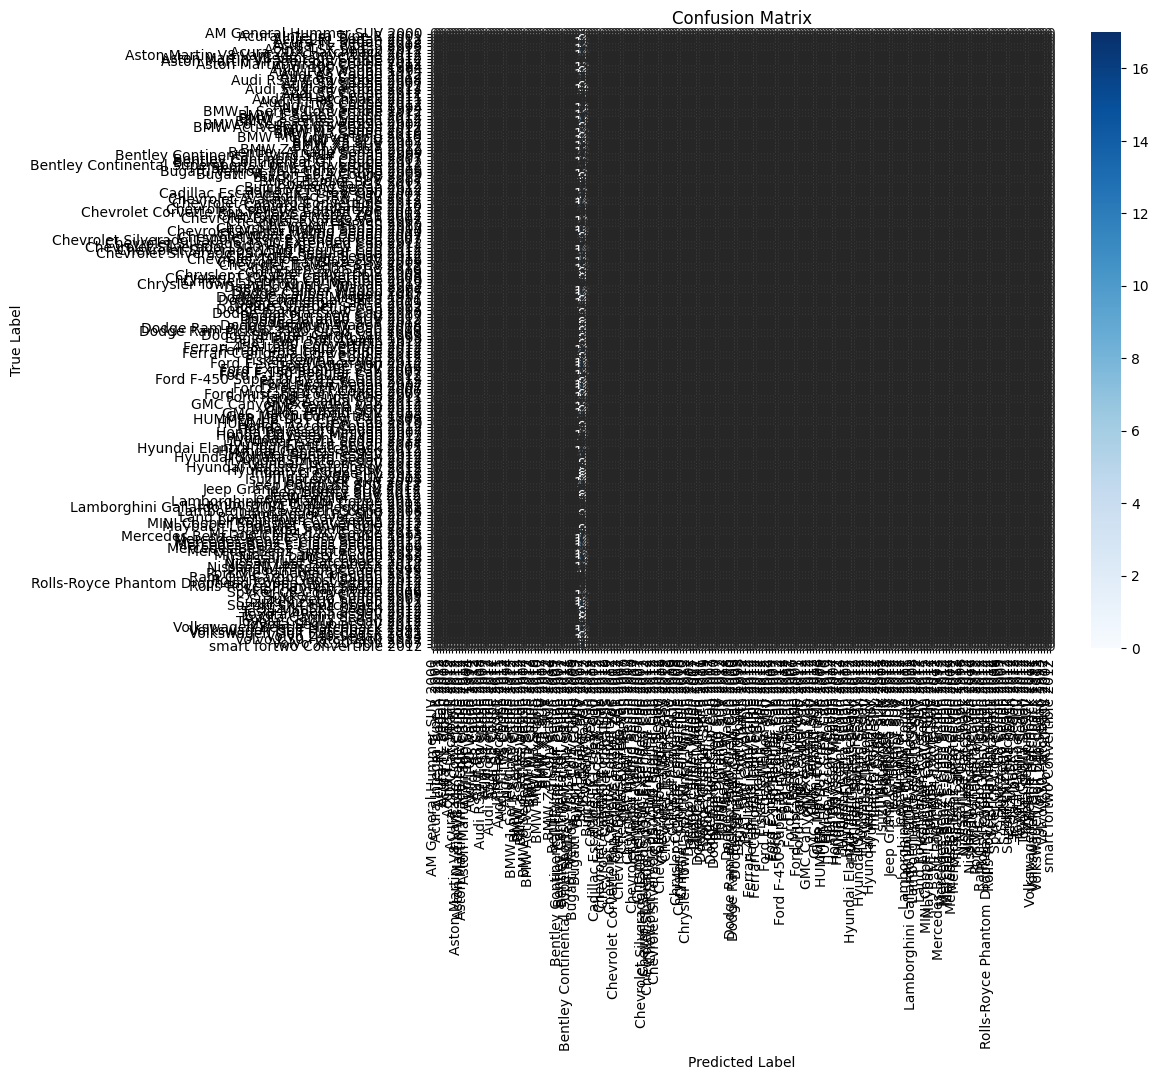

In [55]:
# Compute confusion matrix
cm = confusion_matrix(y_val_true, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

**Observation:**
- The model is not doing well due to 
- exteremely low accuracy
- High Precision and Very low Recall
  
**Further Actions could be**
- Check for Data Imbalance
- Fine tune parameters and retrain the model


7. Summary

Mobilenet and Alexnet are light weight models, hence we decide to drop these two from further fine tunning of the models.

Googlenet and Resnet further in next milestone will undergo hyper parameter tunning as commonly data imbalance and accuracy is less compared to loss